# Statistical comparison of errors

In [1]:
import os
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

from core import stats, utils

Create a folder for evaluation data.

In [2]:
os.makedirs("../../evaluation/", exist_ok=True)

In [2]:
# which variables to evaluate
eval_vars = [
    "edge_count",
    "edge_length",
    "node_count",
    "avg_degree",
    "stroke_count",
    "stroke_length_sum",
    "stroke_length_max",
]

# which methods to evaluate
methods_to_evaluate = [
    "revised_manual",
    "cityseer",
    "original",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
    "neatnet",
]

methods_to_compare = [
    "cityseer",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
    "neatnet",
]

Generate evaluation grids and fill the with evaluation variables. At the same time, compute Euclidean distance between each method and a manual baseline.

In [5]:
for fua in utils.fua_city:
    print(f"Generating for {fua}")
    # read in base data
    meta = utils.read_sample_data()
    geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
    city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

    gdf_orig = utils.read_original(fua)
    proj_crs = gdf_orig.crs

    # Make grid
    base_grid = utils.make_grid(fua, 9, proj_crs)

    # get info on cells with revised data
    deltas = gpd.read_file(f"../../revision/{fua}/deltas_updated.gpkg")

    # read results from all methods into dict
    methods = {}

    for method in methods_to_evaluate:
        print(f"   Reading in results for {method}")
        gdf = utils.read_results(fua, method, proj_crs)

        # print("     getting graph")
        gdf = gdf[~gdf.normalize().duplicated()].copy().reset_index(drop=True)
        G = mm.gdf_to_nx(gdf, length="length", integer_labels=True)

        nodes, edges = mm.nx_to_gdf(G)

        # add node degrees
        # print("     adding node degree")
        nodes = stats.add_node_degree(nodes, G)

        # add stroke IDs
        # print("     measuring coins")
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            if method == "parenx-skeletonize":
                coins = mm.COINS(edges.set_geometry(edges.simplify(.5)), angle_threshold=120, flow_mode=True)
            else:
                coins = mm.COINS(edges, angle_threshold=120, flow_mode=True)
        edges["stroke_id"] = coins.stroke_attribute()
        stroke_gdf = coins.stroke_gdf()

        methods[method] = {}
        methods[method]["gdf"] = gdf
        methods[method]["graph"] = G
        methods[method]["nodes"] = nodes
        methods[method]["edges"] = edges

        ### grid with stats eval for this method only
        grid = base_grid.copy()

        # print("     measuring grid edge")
        # add ratio columns to grid
        grid[["edge_count", "edge_length"]] = grid.apply(
            lambda x: stats.get_edge_stats(edges, x.geometry),  # noqa: B023
            axis=1,
            result_type="expand",
        )

        # print("     measuring grid node")
        grid[["node_count", "node_degrees", "avg_degree"]] = grid.apply(
            lambda x: stats.get_node_stats(nodes, x.geometry),  # noqa: B023
            axis=1,
            result_type="expand",
        )

        # print("     measuring stroke")
        grid[["stroke_count", "stroke_length_sum", "stroke_length_max"]] = grid.apply(
            lambda x: stats.get_stroke_stats(edges, stroke_gdf, x.geometry),  # noqa: B023
            axis=1,
            result_type="expand",
        )

        # add info on which cells have to be verified still
        grid["to_verify_total"] = deltas["to_verify_total"]

        # save grid to dict
        methods[method]["grid"] = grid

        # save to a file
        grid.to_file(f"../../evaluation/{fua}.gpkg", layer=method)
    
    # get euclidean distance between the distributions
    deltas = {}
    for eval_var in eval_vars:
        deltas[eval_var] = {}
        for method in methods_to_compare:
            delta_comp = (
                methods["revised_manual"]["grid"][eval_var]
                - methods[method]["grid"][eval_var]
            ) ** 2

            delta = np.sqrt((delta_comp).sum())
            deltas[eval_var][method] = delta

    # plot the distance by eval variable
    fig, axs = plt.subplots(7, figsize=(6, 18))
    for i, eval_var in enumerate(eval_vars):
        s = pd.Series(deltas[eval_var])
        s.plot.barh(ax=axs.flat[i])
        axs.flat[i].axvline(s.min(), color="coral", linestyle="--")
        axs.flat[i].set_xlabel(eval_var)
        plt.tight_layout()
        fig.savefig(
            f"../../plots/evaluation/{fua}/euclidean_distance.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

Generating for 1133
   Reading in results for revised_manual
   Reading in results for cityseer
   Reading in results for original
   Reading in results for osmnx
   Reading in results for parenx-voronoi
   Reading in results for parenx-skeletonize
   Reading in results for neatnet
Generating for 869
   Reading in results for revised_manual
   Reading in results for cityseer
   Reading in results for original
   Reading in results for osmnx
   Reading in results for parenx-voronoi
   Reading in results for parenx-skeletonize
   Reading in results for neatnet
Generating for 4617
   Reading in results for revised_manual
   Reading in results for cityseer
   Reading in results for original
   Reading in results for osmnx
   Reading in results for parenx-voronoi
   Reading in results for parenx-skeletonize
   Reading in results for neatnet
Generating for 809
   Reading in results for revised_manual
   Reading in results for cityseer
   Reading in results for original
   Reading in results 

## Statistical comparison

Compare the results with the manually simplified networks using xi correlation.

In [3]:
fua = 1133

In [4]:
data = {}
for method in methods_to_evaluate:
    data[method] = gpd.read_file(f"../../evaluation/{fua}.gpkg", layer=method)

In [7]:
stat_result = pd.DataFrame(columns=["statistics", "pvalue"])

for method in methods_to_compare:
    result = scipy.stats.chatterjeexi(data[method].node_count, data["revised_manual"].node_count)
    stat_result.loc[method] = [result.statistic, result.pvalue]

<Axes: >

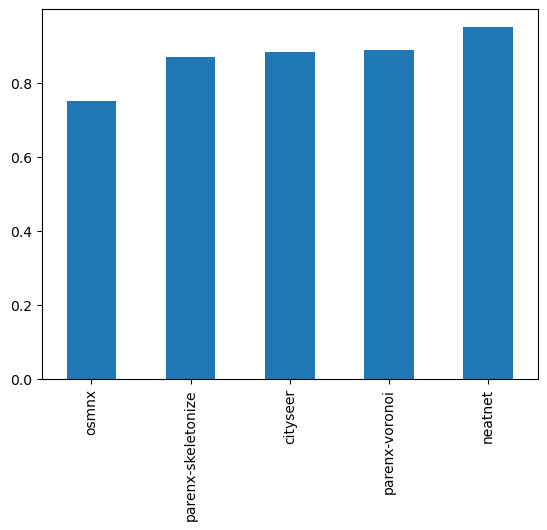

In [10]:
stat_result.statistics.sort_values().plot.bar()

In [20]:
for fua in utils.fua_city:
    data = {}
    for method in methods_to_evaluate:
        data[method] = gpd.read_file(f"../../evaluation/{fua}.gpkg", layer=method)

    # plot the distance by eval variable
    fig, axs = plt.subplots(7, figsize=(6, 18))

    for i, eval_var in enumerate(eval_vars):
        stat_result = pd.DataFrame(columns=["statistics", "pvalue"])
        for method in methods_to_compare:
            result = scipy.stats.chatterjeexi(data[method][eval_var].fillna(0), data["revised_manual"][eval_var].fillna(0))
            stat_result.loc[method] = [result.statistic, result.pvalue]

        if (stat_result.pvalue > 0.01).any():
            print(fua, eval_val, 'pvalue issue')
        stat_result.statistics.plot.barh(ax=axs.flat[i])
        axs.flat[i].axvline(stat_result.statistics.max(), color="coral", linestyle="--")
        axs.flat[i].set_xlabel(f"xi for {eval_var}")
        plt.tight_layout()
        fig.savefig(
            f"../../plots/evaluation/{fua}/xi_correlation.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()

In [ ]:
    gdf_orig = utils.read_original(fua)
    proj_crs = gdf_orig.crs

In [21]:
wuhan_orig = utils.read_original(8989)
wuhan_cityseer = utils.read_results(8989, 'cityseer', wuhan_orig.crs)
wuhan_neatnet = utils.read_results(8989, 'neatnet', wuhan_orig.crs)

In [22]:
from folium import LayerControl

In [ ]:
m = wuhan

In [23]:
wuhan_orig.shape

(92667, 1)

In [24]:
wuhan_cityseer.shape

(25666, 1)

In [25]:
wuhan_neatnet.shape

(16298, 2)